### ***Importing all the required libraries:***

In [1]:
!pip3 install torchinfo

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## **Step 1: Loading the dataset & Visualising:**

This part of the notebook verifies the images in the dataset, uses a function called *display some images()* to visualize a grid of sample images from the training dataset along with their corresponding class labels. This step also applies transformation to convert PIL images (from loading the dataset) to tensors and normalize pixel values to the range [-1, 1]

In [3]:
# Define the transformation -> to handle images as Tensor objects
transform = transforms.Compose([
    transforms.ToTensor(),                # automatically converts a PIL image (0–255) into a floatTensor (0–1)
    transforms.Normalize((0.5,), (0.5,))   # shifts to [-1, 1]
])

# dataset loading
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataset, test_dataset

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 220kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.0MB/s]


(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

### ***Checking what the dataset looks like:***

Through this, we see that Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training images and 10,000 test images, each represented as 28$\times$28 grayscale across 10 different fashion categories.

In [4]:
print("Number of Training images: ",len(train_dataset))
print("Number of Testing images: ",len(test_dataset))
print("Size of each image: ", len(train_dataset[0][0][0][0]), "x", len(train_dataset[0][0][0]))
print("Channels of each image: ", len(train_dataset[0][0]))

Number of Training images:  60000
Number of Testing images:  10000
Size of each image:  28 x 28
Channels of each image:  1


In [5]:
print("Sample Image:")
image, label = train_dataset[0]
print('Shape:', image.shape, 'Label:', label)
print(train_dataset[0])

Sample Image:
Shape: torch.Size([1, 28, 28]) Label: 9
(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1

### ***Visualising some of the images randomly against their labels:***

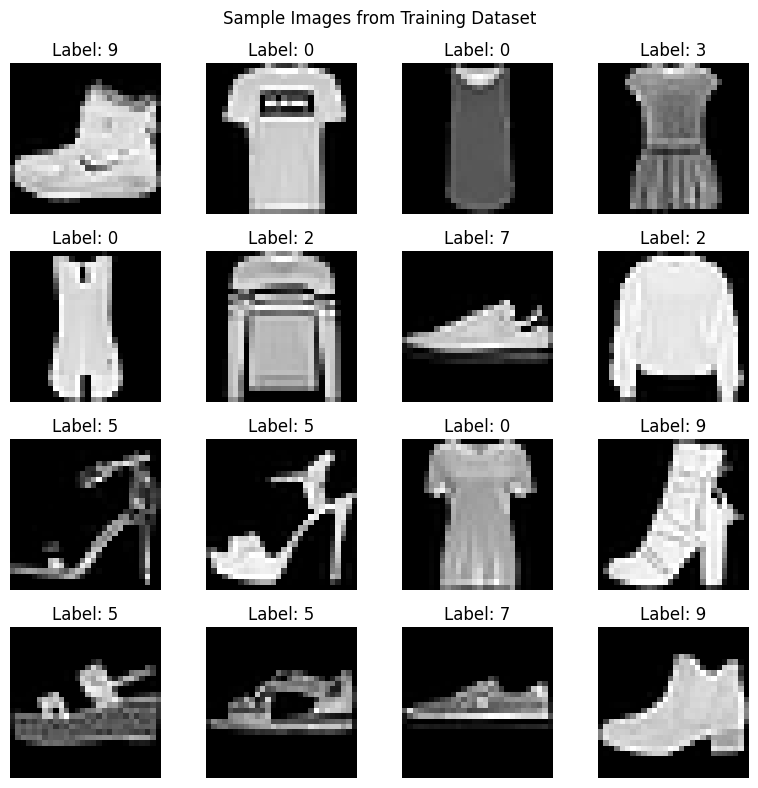

In [6]:
def display_some_images(dataset, rows=4, cols=4, cmap='gray', figsize=(8, 8)):

    def get_image_info(dataset, index):
        img, lbl = dataset[index]
        return img.numpy().squeeze(), lbl

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        img_data, lbl = get_image_info(dataset, idx)
        ax.imshow(img_data, cmap=cmap)
        ax.set_title(f"Label: {lbl}")
        ax.axis("off")

    plt.suptitle("Sample Images from Training Dataset", fontsize=12)
    plt.tight_layout()
    plt.show()

display_some_images(train_dataset)


### ***Labels info***:
0	T-shirt/top <br>
1	Trouser <br>
2	Pullover <br>
3	Dress <br>
4	Coat <br>
5	Sandal <br>
6	Shirt <br>
7	Sneaker <br>
8	Bag <br>
9	Ankle boot

In [7]:
class_labels = {0:'T-shirt/top', 1:'Trouser', 2: 'Pullover', 3: 'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}
class_labels

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

# **Step 2: Define Dataloaders for CNN's/ML Algo's & see what the batches look like**

Through this, we see what the batches look like. The dataset has been loaded using PyTorch's DataLoader with a batch size of 64. Shuffling with randmoness has been used for the training data, while the test data remains unshuffled to maintain consistency in evaluation.

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
# First batch of images in the dataloader:
for images,labels in train_loader:
    break

images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [10]:
# see their labels
print('Labels: ', labels.numpy())
print(len(labels.numpy()))

Labels:  [5 3 9 7 1 2 5 5 3 8 7 2 7 8 8 5 1 3 7 1 6 2 2 6 9 8 5 2 7 4 1 9 1 0 6 5 0
 0 2 0 9 1 1 7 8 2 0 9 8 2 6 5 1 2 5 8 6 0 7 4 5 7 0 0]
64


# **Step 3: Trying some classical ML Algorithms for initial Testing:**

Since scikit-learn models require flattened input data rather than the 4D tensor format (batch_size, channels, height, width) used by PyTorch, we do preprocessing to convert the data.

In [11]:
# convert the data from 4d batches by PyTorch into flattened numpy arrays as needed by scikit-learn

def prepare_data(train_loader, test_loader):
  X_train, y_train = [], []
  X_test, y_test = [], []

  # Process training data
  for images, labels in train_loader:
    X_train.append(images.view(images.size(0), -1).cpu().numpy()) # Flatten image (batch size, 1, 28, 28) -> (batch size, 784)
    y_train.append(labels.cpu().numpy())

  # Process testing data
  for images, labels in test_loader:
    X_test.append(images.view(images.size(0), -1).cpu().numpy()) # Flatten image (batch size, 1, 28, 28) -> (batch size, 784)
    y_test.append(labels.cpu().numpy())

  # Concatenate all batches into single numpy arrays
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)
  X_test = np.concatenate(X_test)
  y_test = np.concatenate(y_test)

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_data(train_loader, test_loader)
print(len(X_train))
print(len(y_train))

60000
60000


In [12]:
# For each model, after getting predictions:
def evaluate_model(y_test, preds, model_name):
    print(classification_report(y_test, preds, target_names=class_labels.values()))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels.values(),
                yticklabels=class_labels.values())
    plt.title(f'{model_name} ; Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

Before trying out how well does the CNN perform, I tried some different ML algorithms as benchmarks. The inspiration for using these ML algorithms has been taken from - http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/

### ***Logistic regression (Multi-Class):***



First, we try out the logistic regression with one-vs-rest (OVR) multi-class strategy using different regularization strengths (C values). The regularization parameter C controls model complexity, where smaller values indicate stronger regularization. <br>

C=0.1: 84.26% accuracy <br>
C=1.0: 84.29% accuracy <br>
C=10.0: 84.15% accuracy <br>

Even though all regularization strengths almost give similar results, When C=1.0 (which is a balanced value between 0.1 and 10), we see that the model provides the best result.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Logistic Regression Accuracy (C=0.1):: 84.26%
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.73      0.73      0.73      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.73      0.77      0.75      1000
      Sandal       0.94      0.91      0.92      1000
       Shirt       0.64      0.54      0.59      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.92      0.95      0.94      1000
  Ankle boot       0.95      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



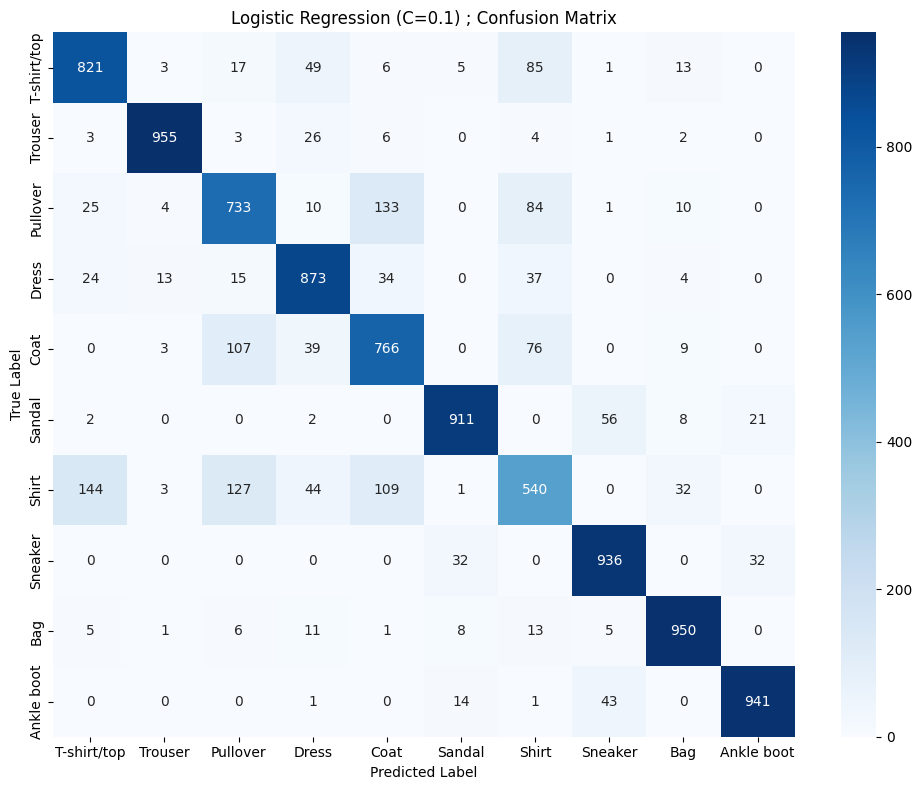

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Logistic Regression Accuracy (C=1):: 84.29%
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.82      0.81      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.72      0.73      0.73      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.73      0.76      0.74      1000
      Sandal       0.94      0.92      0.93      1000
       Shirt       0.64      0.54      0.59      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.92      0.94      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



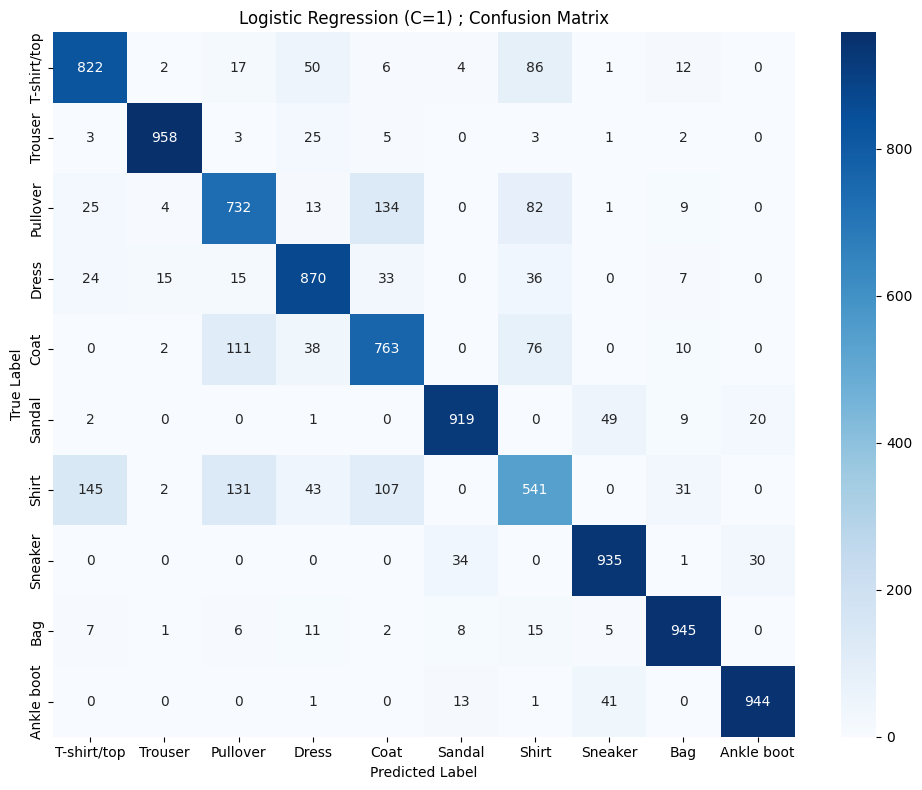

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Logistic Regression Accuracy (C=10):: 84.15%
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.81      0.80      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.72      0.73      0.72      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.72      0.76      0.74      1000
      Sandal       0.94      0.92      0.93      1000
       Shirt       0.64      0.55      0.59      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.92      0.94      0.93      1000
  Ankle boot       0.95      0.94      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



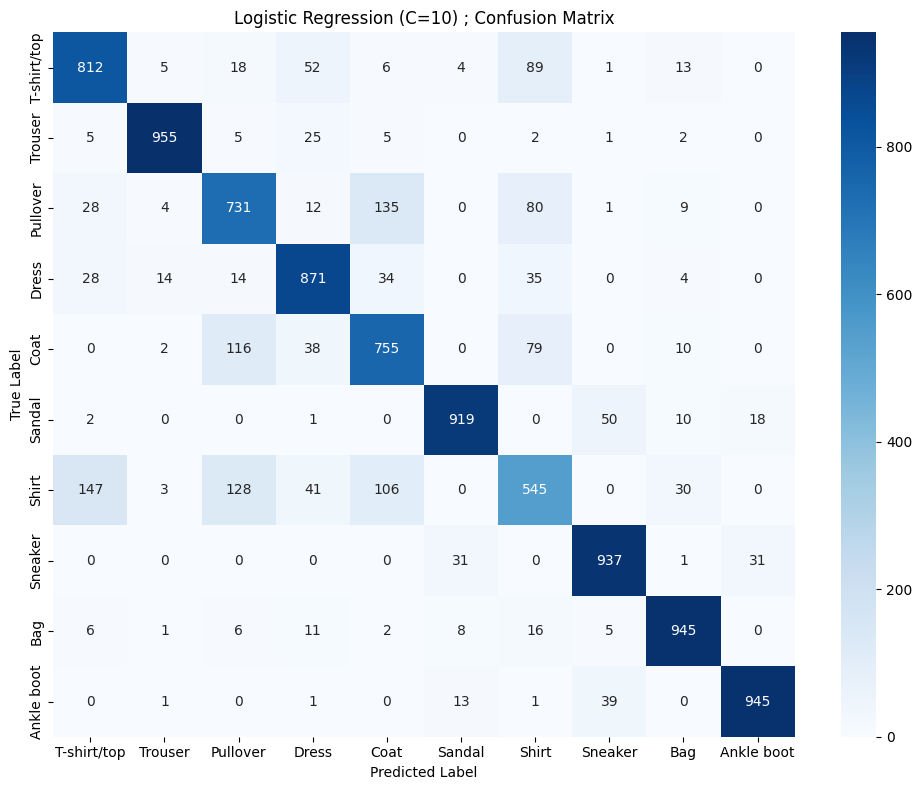

In [13]:
# n_jobs=-1 tells scikit-learn to use all available CPU cores for speed
def logistic_regression(C, X_train, y_train, X_test, y_test):
  log_model = LogisticRegression(
    C=C,
    solver='liblinear',
    multi_class='ovr',
    max_iter=300,
    n_jobs=-1,
    tol=1e-2,   # Early stopping if improvement is small
    verbose=0)

  log_model.fit(X_train, y_train)

  preds = log_model.predict(X_test)
  acc = accuracy_score(y_test, preds)
  print(f"Logistic Regression Accuracy (C={C}):: {acc*100:.2f}%")
  evaluate_model(y_test, preds, f"Logistic Regression (C={C})")
  return acc

for C in [0.1, 1, 10]:
  logistic_regression(C, X_train, y_train, X_test, y_test)

### ***Random Forest:***


For the random forest classifier, I went with 100 estimators and trained using the Gini impurity criterion. Random Forests are an ensemble method that combine multiple decision trees to improve prediction accuracy and reduce overfitting.

Accuracy achieved: 87.64%

Random Forest Accuracy: 87.64%
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.84      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.77      0.80      0.78      1000
       Dress       0.88      0.91      0.89      1000
        Coat       0.77      0.82      0.79      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.72      0.60      0.65      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



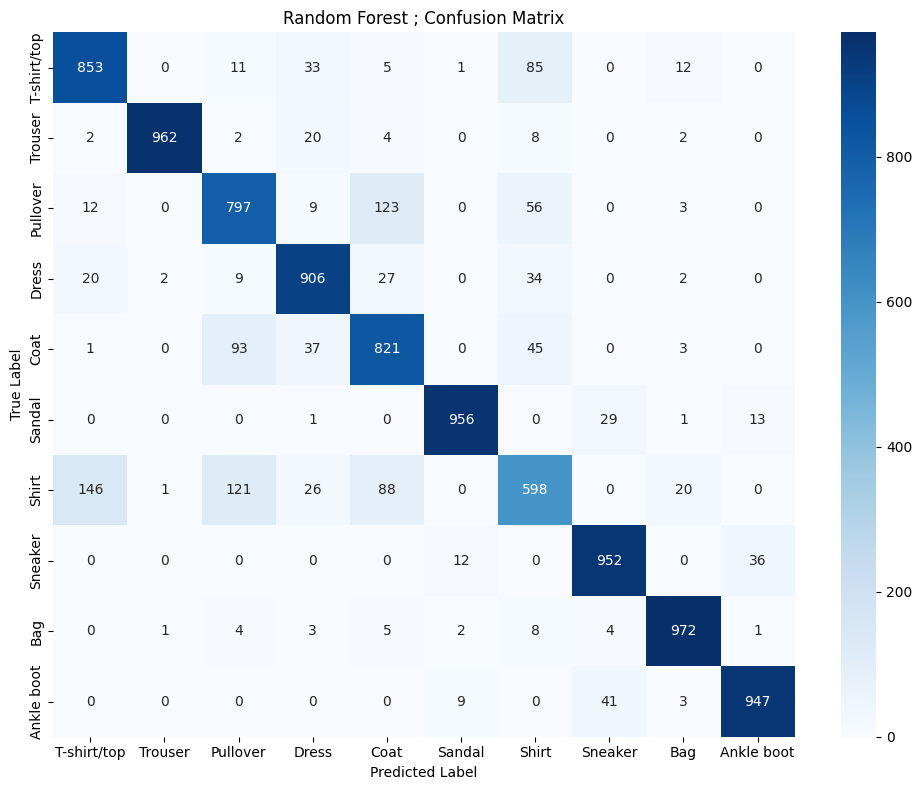

In [14]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  n_jobs=-1,
                                  max_depth=100,
                                  criterion='gini',
                                  random_state=42)
rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Random Forest Accuracy: {acc*100:.2f}%")
evaluate_model(y_test, preds, "Random Forest")

### ***K-Nearest Neighbors with diff values of K:***


Lastly, I tried KNN with different numbers of neighbors using Manhattan distance (L1) and distance-weighted voting, where closer neighbors have greater influence on predictions.

K=3: 85.96% accuracy <br>
K=5: 86.15% accuracy <br>
K=7: 86.13% accuracy <br>

With K=5, we see the best accuracy.

K-Nearest Neighbors Accuracy (K=3): 85.96%
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.84      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.80      0.76      1000
       Dress       0.90      0.87      0.89      1000
        Coat       0.77      0.76      0.76      1000
      Sandal       0.99      0.91      0.95      1000
       Shirt       0.63      0.58      0.61      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.98      0.95      0.96      1000
  Ankle boot       0.92      0.97      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



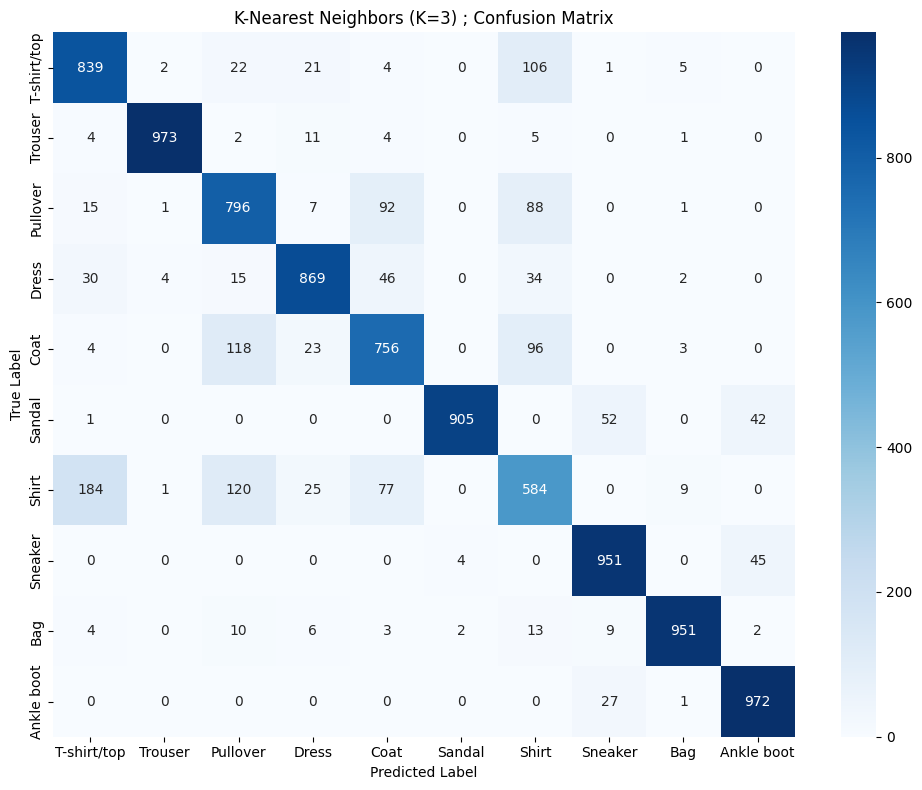

K-Nearest Neighbors Accuracy (K=5): 86.15%
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.85      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.74      0.79      0.76      1000
       Dress       0.91      0.88      0.89      1000
        Coat       0.77      0.76      0.76      1000
      Sandal       0.99      0.90      0.94      1000
       Shirt       0.64      0.59      0.61      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.98      0.95      0.97      1000
  Ankle boot       0.92      0.97      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



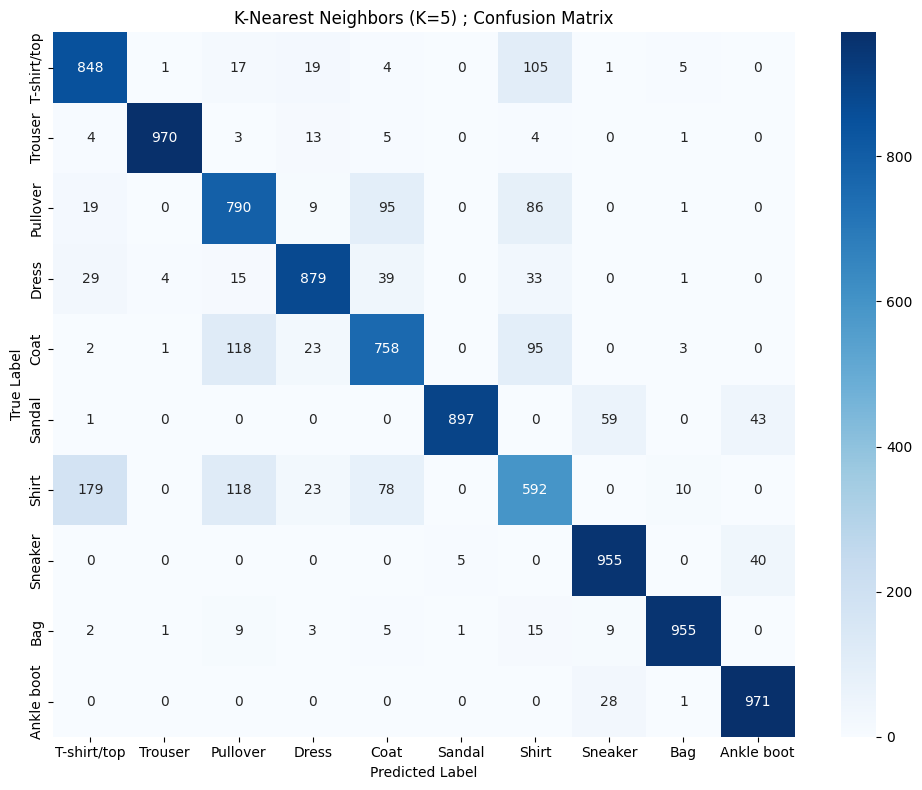

K-Nearest Neighbors Accuracy (K=7): 86.13%
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.86      0.82      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.74      0.80      0.77      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.78      0.76      0.77      1000
      Sandal       0.99      0.88      0.94      1000
       Shirt       0.64      0.59      0.61      1000
     Sneaker       0.90      0.96      0.93      1000
         Bag       0.97      0.95      0.96      1000
  Ankle boot       0.92      0.97      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



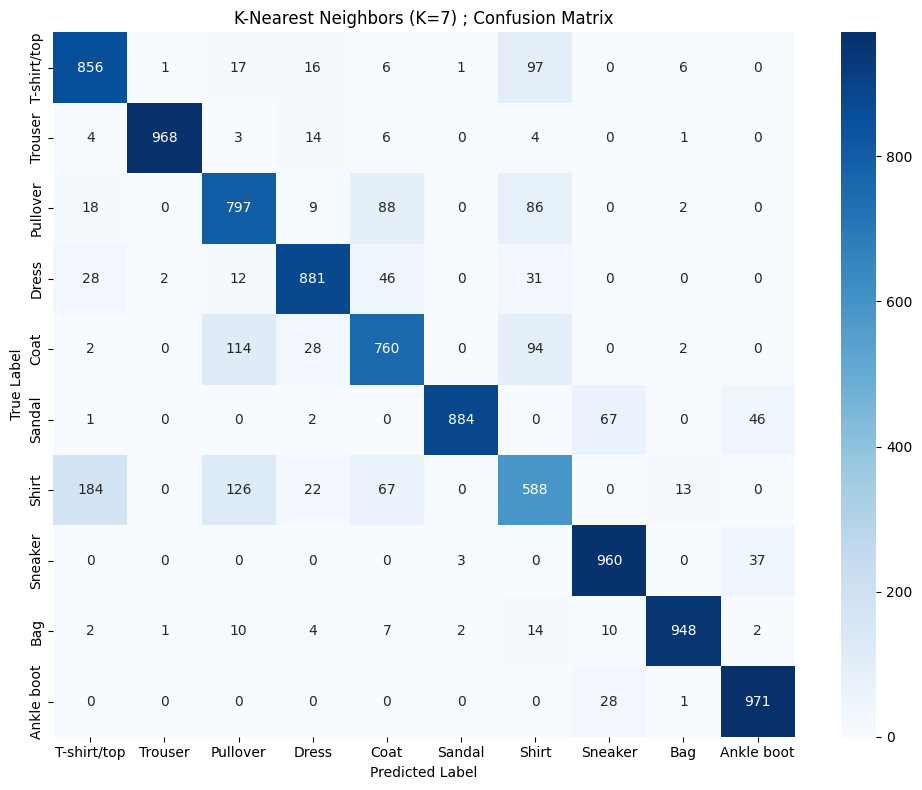

In [15]:
def run_knn(X_train, y_train, X_test, y_test, k_neighbors):
  model = KNeighborsClassifier(n_neighbors=k_neighbors,
                              p=1,               # Manhattan distance (L1)
                              weights='distance', # closer neighbors have more influence
                              n_jobs=-1)

  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  acc = accuracy_score(y_test, preds)
  print(f"K-Nearest Neighbors Accuracy (K={k_neighbors}): {acc*100:.2f}%")
  evaluate_model(y_test, preds, f"K-Nearest Neighbors (K={k_neighbors})")
  return acc

neighbors = [3,5,7]
for n in neighbors:
  run_knn(X_train, y_train, X_test, y_test, n)

## **Analysis after all 3 ML Algorithms with variations:**

Random Forest achieved the best performance (87.64%), followed by KNN (86.15%) and Logistic Regression (84.29%), which shows that ensemble method perform better and captures the patterns better.

Based on the categories, Trousers, Bags, Ankle boots, and Sneakers achieved strong F1-scores (0.92-0.98) maybe due to distinctive visual features. However, Shirts showed the poorest performance (F1: 0.59-0.65)

Overall since the accuracies are between 85-87 across all algorithms that we tried, this indicates that traditional ML models perform just fine (not the best) and do struggle with fine-grained distinctions between visually similar fashion items.

# **Step 4: Different CNN Model Architectures for Trial:**

In [16]:
# 2-layer CNN

class TwoLayerCNN(nn.Module):
  def __init__(self):
    super(TwoLayerCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))  # 28x28 -> 14x14
    x = self.pool(self.relu(self.conv2(x)))  # 14x14 -> 7x7

    x = x.view(-1, 64 * 7 * 7)               # flatten for fully connected layers
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.fc2(x)
    return x         # x.shape = [64, 10] = [batch_size (no of imgs), 10 features for each img]


m = TwoLayerCNN()
# See model summary
summary(m, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
TwoLayerCNN                              [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 32, 14, 14]          --
├─Conv2d: 1-4                            [64, 64, 14, 14]          18,496
├─ReLU: 1-5                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 64, 7, 7]            --
├─Linear: 1-7                            [64, 128]                 401,536
├─ReLU: 1-8                              [64, 128]                 --
├─Dropout: 1-9                           [64, 128]                 --
├─Linear: 1-10                           [64, 10]                  1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 273.85
Input size (MB): 0.20
Forwar

**Simple CNN reasoning:**

Since a 2-layer implementation using Keras exists [1], I used that as an inspiration and developed the PyTorch SimpleCNN with some tweaks. Both models utilize two main Conv2d layers (with 32 and 64 output channels, respectively) and a 3x3 kernel size and a standard two-layer fully-connected block (128 hidden neurons, 10 output neurons).

However, unlike the Keras model, which pools once after two convolutions, I applied a Max Pooling layer immediately following each convolution in my model. This aggressively reduces the feature map size from $28 \times 28 \to 14 \times 14 \to 7 \times 7$. And I also tried simplified regularization, using a lower dropout rate (0.25) and omitting the dropout on the convolutional output.

[1] https://gist.github.com/kashif/76792939dd6f473b7404474989cb62a8#file-fashion_mnist_cnn-py

In [17]:
# 4-conv layer CNN

class FourLayerCNN(nn.Module):
  def __init__(self):
    super(FourLayerCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 3 * 3, 256)
    self.fc2 = nn.Linear(256, 10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = self.relu(self.conv1(x))             # no pooling after first layer
    x = self.pool(self.relu(self.conv2(x)))  # 28x28 -> 14x14
    x = self.relu(self.conv3(x))             # no pooling after third layer
    x = self.pool(self.relu(self.conv4(x)))  # 14x14 -> 7x7
    x = self.pool(x)  # 7x7 -> 3x3           # final Max Pool layer

    x = x.view(-1, 128 * 3 * 3)              # Flatten into 1D vector
    x = self.dropout(self.relu(self.fc1(x)))
    x = self.fc2(x)
    return x                          # x.shape = [64, 10] = [batch_size (no of imgs), 10 features for each img]

m = FourLayerCNN()
# See model summary
summary(m, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FourLayerCNN                             [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─Conv2d: 1-3                            [64, 64, 28, 28]          18,496
├─ReLU: 1-4                              [64, 64, 28, 28]          --
├─MaxPool2d: 1-5                         [64, 64, 14, 14]          --
├─Conv2d: 1-6                            [64, 128, 14, 14]         73,856
├─ReLU: 1-7                              [64, 128, 14, 14]         --
├─Conv2d: 1-8                            [64, 128, 14, 14]         147,584
├─ReLU: 1-9                              [64, 128, 14, 14]         --
├─MaxPool2d: 1-10                        [64, 128, 7, 7]           --
├─MaxPool2d: 1-11                        [64, 128, 3, 3]           --
├─Linear: 1-12                           [64, 256]                 295,

**Deep CNN reasoning:**

From 2 layer CNN, I tried extending it to 4 layer now. and also progressively increased channels from $32 \to 64 \to 128$.
I also applied the pooling only after conv2 and conv4, plus a final pooling, this reduces feature maps from $28 \times 28 \to 14 \times 14 \to 7 \times 7 \to 3 \times 3$

other than that, All layers use 3x3 kernels with padding=1 and ReLU activation, same as above.The fully-connected block uses 256 hidden neurons with 0.3 dropout to prevent overfitting.

In [18]:
# CNN with Batch Normalization

class BatchNormCNN(nn.Module):
  def __init__(self):
    super(BatchNormCNN, self).__init__()
    self.conv1_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1_1 = nn.BatchNorm2d(32)
    self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.bn1_2 = nn.BatchNorm2d(32)

    self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2_1 = nn.BatchNorm2d(64)
    self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.bn2_2 = nn.BatchNorm2d(64)

    self.pool = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(64 * 7 * 7, 256)
    self.bn_fc = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)

  def forward(self, x):
    # Block 1: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> pool
    x = self.relu(self.bn1_1(self.conv1_1(x)))
    x = self.relu(self.bn1_2(self.conv1_2(x)))
    x = self.pool(x)                 # 28x28 -> 14x14

    # Block 2: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> pool
    x = self.relu(self.bn2_1(self.conv2_1(x)))
    x = self.relu(self.bn2_2(self.conv2_2(x)))
    x = self.pool(x)    # 14x14 -> 7x7

    x = x.view(-1, 64 * 7 * 7)        # Flatten into 1D vector
    x = self.dropout(self.relu(self.bn_fc(self.fc1(x)))) # also apply BatchNorm1d for the FC layer
    x = self.fc2(x)
    return x                          # x.shape = [64, 10] = [batch_size (no of imgs), 10 features for each img]

m = BatchNormCNN()
# See model summary
summary(m, input_size=(64, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormCNN                             [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─BatchNorm2d: 1-2                       [64, 32, 28, 28]          64
├─ReLU: 1-3                              [64, 32, 28, 28]          --
├─Conv2d: 1-4                            [64, 32, 28, 28]          9,248
├─BatchNorm2d: 1-5                       [64, 32, 28, 28]          64
├─ReLU: 1-6                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [64, 32, 14, 14]          --
├─Conv2d: 1-8                            [64, 64, 14, 14]          18,496
├─BatchNorm2d: 1-9                       [64, 64, 14, 14]          128
├─ReLU: 1-10                             [64, 64, 14, 14]          --
├─Conv2d: 1-11                           [64, 64, 14, 14]          36,928
├─BatchNorm2d: 1-12                      [64, 64, 14, 14]          128
├

**BatchNorm CNN reasoning:**

Since I wanted to try batch normalisation aswell, I took inspiration from [2] and used stacked convolutional blocks (32 filters in the first block, increasing to 64 filters in the second block) and applied pooling after each block.

I applied Batch Normalization after every convolutional layer ($\text{Conv} \to \text{BN} \to \text{ReLU}$) and also in the final FC block. other than that, like above we stick with 3x3 kernels but omitted dropout in convolutional blocks (relying on BN's implicit regularization)

[2] https://github.com/khanguyen1207/My-Machine-Learning-Corner/tree/master/Zalando%20MNIST

# **Step 5: Define the training & evaluating loops for Training & Testing batches:**

The functions below are already commented, but to summarise it, this block defines the training loop (which involves forward propagation as well as backward propagation) & after training, we evaluate the model on the test data during each epoch, which shows us the accuracy of predictions on unseen data.

For better understading of how the trend changes, I've also defined a function called *plot_training_history()* that shows the loss and accuracy changing over each epoch for each of the models.

In [19]:
def train_one_epoch(model, loader, criterion, optimizer, device):

  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  # tqdm just shows a progress bar while training
  for images, labels in tqdm(loader, desc="Training", leave=False):

    # Loops through all mini-batches from the DataLoader, where each has size:
    # images: [64, 1, 28, 28]
    # labels: [64]

    # Forward propagation:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images) # Find the predictions

    # Backward propagation:
    loss = criterion(outputs, labels) # The criterion (here, nn.CrossEntropyLoss) compares predictions vs. true labels

    loss.backward()  # computes gradients for all weights (how much each contributed to the error)
    optimizer.step()  # updates model weights to reduce the loss.

    running_loss += loss.item()
    _, predicted = outputs.max(1)  # finds the index of the highest logit value, indicating that the model is strongly predicting that class

    total += labels.size(0)        # total number of labels
    correct += predicted.eq(labels).sum().item()  # how many of the predictions were correct

    accuracy_percentage = 100. * correct / total

  return running_loss / len(loader), accuracy_percentage

In [20]:
def evaluate(model, loader, criterion, device):

  # Same implementation as above, but this function just does the forward propagation as we are evaluating
  # i.e: we are not changing the weights, just using the existing learned model so far to see the accuracy on unseen images

  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in tqdm(loader, desc="Evaluating", leave=False):

      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      loss = criterion(outputs, labels)

      running_loss += loss.item()
      _, predicted = outputs.max(1)

      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

      accuracy_percentage = 100. * correct / total

  return running_loss / len(loader), accuracy_percentage

In [21]:
def train_model(model, train_loader, test_loader, epochs, lr):
  model = model.to(device)

  # Adam is a common choice for the optimizer, it will manage how the model's parameters (weights and biases) are updated
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # lists to store metrics like loss and accuracy over each epoch
  train_losses, train_accs = [], []
  test_losses, test_accs = [], []

  for epoch in range(epochs):
      print(f"\nEpoch {epoch+1}/{epochs}")

      # Training Phase
      # updates the model's weights and returns the average loss and accuracy for the training set
      train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

      # Evaluation Phase
      # doesn't update the weights and returns the loss and accuracy for the test set
      test_loss, test_acc = evaluate(model, test_loader, criterion, device)

      train_losses.append(train_loss)
      train_accs.append(train_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

      print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
      print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

  return train_losses, train_accs, test_losses, test_accs

In [22]:
def plot_training_history(results_dict, models_list):
  # 3 models * 2 metrics (Loss, Acc) = 6 subplots
  fig, axes = plt.subplots(len(models_list), 2, figsize=(16, 5 * len(models_list)))

  # hyperparameter keys
  tuning_combinations = ['LR0.001_E20', 'LR0.001_E30', 'LR0.0005_E20', 'LR0.0005_E30']

  for i, model_name in enumerate(models_list):

    ax_loss = axes[i, 0] # for loss plot


    for key, history in results_dict.items():
        if key.startswith(model_name):
          # Extract the hyperparameter combination string
          hp_str = key.replace(f"{model_name}_", "")

          # training loss plots
          ax_loss.plot(history['train_loss'],
                        label=f'{hp_str} (train)',
                        linestyle='--')

          # test loss plots
          ax_loss.plot(history['test_loss'],
                        label=f'{hp_str} (test)')

    ax_loss.set_title(f'Loss for {model_name} (Train & Test)')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend(loc='upper right', fontsize='small')
    ax_loss.grid(True)



    ax_acc = axes[i, 1]  # for accuracy plot

    for key, history in results_dict.items():
        if key.startswith(model_name):
          hp_str = key.replace(f"{model_name}_", "")

          # training accuracy plots
          ax_acc.plot(history['train_acc'],
                      label=f'{hp_str} (train)',
                      linestyle='--')

          # test accuracy plots
          ax_acc.plot(history['test_acc'],
                      label=f'{hp_str} (test)')

    ax_acc.set_title(f'Accuracy for {model_name} (Train & Test)')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy (%)')
    ax_acc.legend(loc='lower right', fontsize='small')
    ax_acc.grid(True)

  plt.tight_layout()
  plt.show()

# **Step 6: Experimentation of different models with different learning rates & epochs (grid search method):**

To see which CNN model performs the best and with which configuration, I trained each CNN architecture (SimpleCNN, DeepCNN, and BatchNormCNN) with different hyperparameter combinations. Through a grid search approach, I tested two learning rates (0.001, 0.0005) and two training durations (10, 20 epochs), resulting in four experimental configurations per model.

For each combination, losses and accuracies were recorded throughout the training process. In the end, we determine the best performing model-hyperparameter combination based on final test accuracy.



Training SimpleCNN
Hyperparameters: LR=0.001, Epochs=10



Epoch 1/10


Train Loss: 0.4784 | Train Acc: 82.72%
Test Loss: 0.3248 | Test Acc: 87.89%

Epoch 2/10


Train Loss: 0.3087 | Train Acc: 88.67%
Test Loss: 0.2799 | Test Acc: 89.58%

Epoch 3/10


Train Loss: 0.2640 | Train Acc: 90.31%
Test Loss: 0.2579 | Test Acc: 90.57%

Epoch 4/10


Train Loss: 0.2325 | Train Acc: 91.43%
Test Loss: 0.2525 | Test Acc: 90.45%

Epoch 5/10


Train Loss: 0.2071 | Train Acc: 92.32%
Test Loss: 0.2398 | Test Acc: 91.44%

Epoch 6/10


Train Loss: 0.1880 | Train Acc: 93.05%
Test Loss: 0.2490 | Test Acc: 91.55%

Epoch 7/10


Train Loss: 0.1702 | Train Acc: 93.58%
Test Loss: 0.2372 | Test Acc: 91.54%

Epoch 8/10


Train Loss: 0.1534 | Train Acc: 94.24%
Test Loss: 0.2377 | Test Acc: 92.02%

Epoch 9/10


Train Loss: 0.1390 | Train Acc: 94.75%
Test Loss: 0.2471 | Test Acc: 92.01%

Epoch 10/10


Train Loss: 0.1252 | Train Acc: 95.22%
Test Loss: 0.2470 | Test Acc: 91.95%


Training SimpleCNN
Hyperparameters: LR=0.001, Epochs=20



Epoch 1/20


Train Loss: 0.4820 | Train Acc: 82.58%
Test Loss: 0.3615 | Test Acc: 86.95%

Epoch 2/20


Train Loss: 0.3083 | Train Acc: 88.85%
Test Loss: 0.2927 | Test Acc: 89.53%

Epoch 3/20


Train Loss: 0.2603 | Train Acc: 90.53%
Test Loss: 0.2654 | Test Acc: 90.14%

Epoch 4/20


Train Loss: 0.2283 | Train Acc: 91.69%
Test Loss: 0.2473 | Test Acc: 90.88%

Epoch 5/20


Train Loss: 0.2058 | Train Acc: 92.33%
Test Loss: 0.2389 | Test Acc: 91.88%

Epoch 6/20


Train Loss: 0.1850 | Train Acc: 93.17%
Test Loss: 0.2376 | Test Acc: 91.84%

Epoch 7/20


Train Loss: 0.1651 | Train Acc: 93.88%
Test Loss: 0.2406 | Test Acc: 91.49%

Epoch 8/20


Train Loss: 0.1493 | Train Acc: 94.41%
Test Loss: 0.2500 | Test Acc: 91.72%

Epoch 9/20


Train Loss: 0.1374 | Train Acc: 94.84%
Test Loss: 0.2591 | Test Acc: 91.44%

Epoch 10/20


Train Loss: 0.1202 | Train Acc: 95.41%
Test Loss: 0.2579 | Test Acc: 92.28%

Epoch 11/20


Train Loss: 0.1121 | Train Acc: 95.71%
Test Loss: 0.2530 | Test Acc: 92.23%

Epoch 12/20


Train Loss: 0.1014 | Train Acc: 96.21%
Test Loss: 0.2831 | Test Acc: 92.43%

Epoch 13/20


Train Loss: 0.0950 | Train Acc: 96.41%
Test Loss: 0.2857 | Test Acc: 92.50%

Epoch 14/20


Train Loss: 0.0882 | Train Acc: 96.61%
Test Loss: 0.2950 | Test Acc: 92.24%

Epoch 15/20


Train Loss: 0.0799 | Train Acc: 97.01%
Test Loss: 0.3133 | Test Acc: 92.40%

Epoch 16/20


Train Loss: 0.0749 | Train Acc: 97.14%
Test Loss: 0.3308 | Test Acc: 92.07%

Epoch 17/20


Train Loss: 0.0710 | Train Acc: 97.28%
Test Loss: 0.3325 | Test Acc: 92.35%

Epoch 18/20


Train Loss: 0.0661 | Train Acc: 97.46%
Test Loss: 0.3454 | Test Acc: 92.04%

Epoch 19/20


Train Loss: 0.0618 | Train Acc: 97.64%
Test Loss: 0.3627 | Test Acc: 92.12%

Epoch 20/20


Train Loss: 0.0572 | Train Acc: 97.81%
Test Loss: 0.3792 | Test Acc: 92.32%


Training SimpleCNN
Hyperparameters: LR=0.0005, Epochs=10



Epoch 1/10


Train Loss: 0.5402 | Train Acc: 80.64%
Test Loss: 0.3784 | Test Acc: 86.18%

Epoch 2/10


Train Loss: 0.3526 | Train Acc: 87.28%
Test Loss: 0.3134 | Test Acc: 88.38%

Epoch 3/10


Train Loss: 0.3004 | Train Acc: 89.13%
Test Loss: 0.2953 | Test Acc: 89.16%

Epoch 4/10


Train Loss: 0.2690 | Train Acc: 90.20%
Test Loss: 0.2635 | Test Acc: 90.35%

Epoch 5/10


Train Loss: 0.2463 | Train Acc: 91.03%
Test Loss: 0.2533 | Test Acc: 90.83%

Epoch 6/10


Train Loss: 0.2292 | Train Acc: 91.63%
Test Loss: 0.2454 | Test Acc: 90.89%

Epoch 7/10


Train Loss: 0.2130 | Train Acc: 92.16%
Test Loss: 0.2369 | Test Acc: 91.45%

Epoch 8/10


Train Loss: 0.1963 | Train Acc: 92.83%
Test Loss: 0.2307 | Test Acc: 91.65%

Epoch 9/10


Train Loss: 0.1837 | Train Acc: 93.11%
Test Loss: 0.2327 | Test Acc: 91.46%

Epoch 10/10


Train Loss: 0.1697 | Train Acc: 93.60%
Test Loss: 0.2304 | Test Acc: 92.04%


Training SimpleCNN
Hyperparameters: LR=0.0005, Epochs=20



Epoch 1/20


Train Loss: 0.5258 | Train Acc: 81.05%
Test Loss: 0.3615 | Test Acc: 86.84%

Epoch 2/20


Train Loss: 0.3448 | Train Acc: 87.40%
Test Loss: 0.3185 | Test Acc: 88.13%

Epoch 3/20


Train Loss: 0.2976 | Train Acc: 89.09%
Test Loss: 0.2966 | Test Acc: 88.94%

Epoch 4/20


Train Loss: 0.2668 | Train Acc: 90.19%
Test Loss: 0.2662 | Test Acc: 89.98%

Epoch 5/20


Train Loss: 0.2436 | Train Acc: 91.03%
Test Loss: 0.2549 | Test Acc: 90.59%

Epoch 6/20


Train Loss: 0.2263 | Train Acc: 91.61%
Test Loss: 0.2502 | Test Acc: 90.81%

Epoch 7/20


Train Loss: 0.2099 | Train Acc: 92.29%
Test Loss: 0.2398 | Test Acc: 91.33%

Epoch 8/20


Train Loss: 0.1958 | Train Acc: 92.82%
Test Loss: 0.2400 | Test Acc: 91.22%

Epoch 9/20


Train Loss: 0.1819 | Train Acc: 93.29%
Test Loss: 0.2296 | Test Acc: 91.77%

Epoch 10/20


Train Loss: 0.1693 | Train Acc: 93.69%
Test Loss: 0.2302 | Test Acc: 91.85%

Epoch 11/20


Train Loss: 0.1571 | Train Acc: 94.19%
Test Loss: 0.2304 | Test Acc: 92.12%

Epoch 12/20


Train Loss: 0.1471 | Train Acc: 94.52%
Test Loss: 0.2333 | Test Acc: 92.10%

Epoch 13/20


Train Loss: 0.1361 | Train Acc: 94.97%
Test Loss: 0.2487 | Test Acc: 91.42%

Epoch 14/20


Train Loss: 0.1276 | Train Acc: 95.25%
Test Loss: 0.2367 | Test Acc: 91.59%

Epoch 15/20


Train Loss: 0.1176 | Train Acc: 95.63%
Test Loss: 0.2456 | Test Acc: 92.22%

Epoch 16/20


Train Loss: 0.1075 | Train Acc: 96.04%
Test Loss: 0.2466 | Test Acc: 92.34%

Epoch 17/20


Train Loss: 0.1006 | Train Acc: 96.19%
Test Loss: 0.2575 | Test Acc: 91.86%

Epoch 18/20


Train Loss: 0.0938 | Train Acc: 96.48%
Test Loss: 0.2656 | Test Acc: 91.98%

Epoch 19/20


Train Loss: 0.0863 | Train Acc: 96.78%
Test Loss: 0.2598 | Test Acc: 92.52%

Epoch 20/20


Train Loss: 0.0800 | Train Acc: 96.96%
Test Loss: 0.2727 | Test Acc: 92.39%


Training DeepCNN
Hyperparameters: LR=0.001, Epochs=10



Epoch 1/10


Train Loss: 0.4867 | Train Acc: 82.16%
Test Loss: 0.3458 | Test Acc: 86.80%

Epoch 2/10


Train Loss: 0.2906 | Train Acc: 89.37%
Test Loss: 0.3003 | Test Acc: 88.85%

Epoch 3/10


Train Loss: 0.2410 | Train Acc: 91.23%
Test Loss: 0.2536 | Test Acc: 90.66%

Epoch 4/10


Train Loss: 0.2111 | Train Acc: 92.16%
Test Loss: 0.2418 | Test Acc: 91.43%

Epoch 5/10


Train Loss: 0.1875 | Train Acc: 93.10%
Test Loss: 0.2235 | Test Acc: 91.76%

Epoch 6/10


Train Loss: 0.1684 | Train Acc: 93.86%
Test Loss: 0.2101 | Test Acc: 92.45%

Epoch 7/10


Train Loss: 0.1495 | Train Acc: 94.41%
Test Loss: 0.2192 | Test Acc: 92.24%

Epoch 8/10


Train Loss: 0.1361 | Train Acc: 94.94%
Test Loss: 0.2312 | Test Acc: 92.26%

Epoch 9/10


Train Loss: 0.1203 | Train Acc: 95.40%
Test Loss: 0.2255 | Test Acc: 92.58%

Epoch 10/10


Train Loss: 0.1071 | Train Acc: 95.98%
Test Loss: 0.2433 | Test Acc: 92.68%


Training DeepCNN
Hyperparameters: LR=0.001, Epochs=20



Epoch 1/20


Train Loss: 0.4787 | Train Acc: 82.38%
Test Loss: 0.3451 | Test Acc: 86.73%

Epoch 2/20


Train Loss: 0.2899 | Train Acc: 89.26%
Test Loss: 0.2717 | Test Acc: 89.73%

Epoch 3/20


Train Loss: 0.2401 | Train Acc: 91.22%
Test Loss: 0.2401 | Test Acc: 91.09%

Epoch 4/20


Train Loss: 0.2073 | Train Acc: 92.39%
Test Loss: 0.2393 | Test Acc: 91.42%

Epoch 5/20


Train Loss: 0.1850 | Train Acc: 93.15%
Test Loss: 0.2264 | Test Acc: 91.90%

Epoch 6/20


Train Loss: 0.1666 | Train Acc: 93.86%
Test Loss: 0.2253 | Test Acc: 92.14%

Epoch 7/20


Train Loss: 0.1484 | Train Acc: 94.55%
Test Loss: 0.2264 | Test Acc: 92.64%

Epoch 8/20


Train Loss: 0.1339 | Train Acc: 94.97%
Test Loss: 0.2387 | Test Acc: 92.38%

Epoch 9/20


Train Loss: 0.1215 | Train Acc: 95.44%
Test Loss: 0.2277 | Test Acc: 92.22%

Epoch 10/20


Train Loss: 0.1057 | Train Acc: 96.05%
Test Loss: 0.2652 | Test Acc: 92.19%

Epoch 11/20


Train Loss: 0.0943 | Train Acc: 96.50%
Test Loss: 0.2483 | Test Acc: 92.42%

Epoch 12/20


Train Loss: 0.0856 | Train Acc: 96.81%
Test Loss: 0.2623 | Test Acc: 92.92%

Epoch 13/20


Train Loss: 0.0752 | Train Acc: 97.20%
Test Loss: 0.2945 | Test Acc: 92.64%

Epoch 14/20


Train Loss: 0.0724 | Train Acc: 97.28%
Test Loss: 0.2934 | Test Acc: 92.85%

Epoch 15/20


Train Loss: 0.0638 | Train Acc: 97.56%
Test Loss: 0.2995 | Test Acc: 92.50%

Epoch 16/20


Train Loss: 0.0593 | Train Acc: 97.80%
Test Loss: 0.2996 | Test Acc: 93.08%

Epoch 17/20


Train Loss: 0.0541 | Train Acc: 98.02%
Test Loss: 0.3329 | Test Acc: 92.61%

Epoch 18/20


Train Loss: 0.0570 | Train Acc: 97.94%
Test Loss: 0.3497 | Test Acc: 92.72%

Epoch 19/20


Train Loss: 0.0523 | Train Acc: 98.06%
Test Loss: 0.3428 | Test Acc: 92.52%

Epoch 20/20


Train Loss: 0.0499 | Train Acc: 98.22%
Test Loss: 0.3661 | Test Acc: 92.88%


Training DeepCNN
Hyperparameters: LR=0.0005, Epochs=10



Epoch 1/10


Train Loss: 0.5145 | Train Acc: 81.03%
Test Loss: 0.3453 | Test Acc: 86.93%

Epoch 2/10


Train Loss: 0.3049 | Train Acc: 88.76%
Test Loss: 0.2701 | Test Acc: 90.03%

Epoch 3/10


Train Loss: 0.2545 | Train Acc: 90.64%
Test Loss: 0.2551 | Test Acc: 90.20%

Epoch 4/10


Train Loss: 0.2224 | Train Acc: 91.97%
Test Loss: 0.2336 | Test Acc: 91.21%

Epoch 5/10


Train Loss: 0.1991 | Train Acc: 92.69%
Test Loss: 0.2249 | Test Acc: 91.68%

Epoch 6/10


Train Loss: 0.1789 | Train Acc: 93.40%
Test Loss: 0.2188 | Test Acc: 92.39%

Epoch 7/10


Train Loss: 0.1624 | Train Acc: 93.87%
Test Loss: 0.2181 | Test Acc: 92.48%

Epoch 8/10


Train Loss: 0.1445 | Train Acc: 94.61%
Test Loss: 0.2233 | Test Acc: 92.20%

Epoch 9/10


Train Loss: 0.1291 | Train Acc: 95.22%
Test Loss: 0.2302 | Test Acc: 92.04%

Epoch 10/10


Train Loss: 0.1161 | Train Acc: 95.52%
Test Loss: 0.2246 | Test Acc: 92.78%


Training DeepCNN
Hyperparameters: LR=0.0005, Epochs=20



Epoch 1/20


Train Loss: 0.5279 | Train Acc: 80.47%
Test Loss: 0.3704 | Test Acc: 85.80%

Epoch 2/20


Train Loss: 0.3157 | Train Acc: 88.44%
Test Loss: 0.3095 | Test Acc: 88.21%

Epoch 3/20


Train Loss: 0.2657 | Train Acc: 90.18%
Test Loss: 0.2643 | Test Acc: 89.97%

Epoch 4/20


Train Loss: 0.2306 | Train Acc: 91.44%
Test Loss: 0.2565 | Test Acc: 90.34%

Epoch 5/20


Train Loss: 0.2083 | Train Acc: 92.22%
Test Loss: 0.2308 | Test Acc: 91.32%

Epoch 6/20


Train Loss: 0.1868 | Train Acc: 93.14%
Test Loss: 0.2239 | Test Acc: 91.85%

Epoch 7/20


Train Loss: 0.1724 | Train Acc: 93.57%
Test Loss: 0.2097 | Test Acc: 92.36%

Epoch 8/20


Train Loss: 0.1552 | Train Acc: 94.34%
Test Loss: 0.2258 | Test Acc: 92.22%

Epoch 9/20


Train Loss: 0.1412 | Train Acc: 94.65%
Test Loss: 0.2123 | Test Acc: 92.16%

Epoch 10/20


Train Loss: 0.1264 | Train Acc: 95.26%
Test Loss: 0.2271 | Test Acc: 92.39%

Epoch 11/20


Train Loss: 0.1125 | Train Acc: 95.81%
Test Loss: 0.2247 | Test Acc: 92.64%

Epoch 12/20


Train Loss: 0.1037 | Train Acc: 96.09%
Test Loss: 0.2470 | Test Acc: 92.44%

Epoch 13/20


Train Loss: 0.0925 | Train Acc: 96.50%
Test Loss: 0.2412 | Test Acc: 92.86%

Epoch 14/20


Train Loss: 0.0831 | Train Acc: 96.84%
Test Loss: 0.2576 | Test Acc: 92.37%

Epoch 15/20


Train Loss: 0.0763 | Train Acc: 97.05%
Test Loss: 0.2904 | Test Acc: 92.23%

Epoch 16/20


Train Loss: 0.0685 | Train Acc: 97.32%
Test Loss: 0.2845 | Test Acc: 92.84%

Epoch 17/20


Train Loss: 0.0624 | Train Acc: 97.55%
Test Loss: 0.3099 | Test Acc: 92.62%

Epoch 18/20


Train Loss: 0.0580 | Train Acc: 97.85%
Test Loss: 0.3135 | Test Acc: 92.75%

Epoch 19/20


Train Loss: 0.0534 | Train Acc: 97.91%
Test Loss: 0.3171 | Test Acc: 92.40%

Epoch 20/20


Train Loss: 0.0521 | Train Acc: 98.04%
Test Loss: 0.3496 | Test Acc: 92.74%


Training BatchNormCNN
Hyperparameters: LR=0.001, Epochs=10



Epoch 1/10


Train Loss: 0.3359 | Train Acc: 88.05%
Test Loss: 0.2436 | Test Acc: 91.08%

Epoch 2/10


Train Loss: 0.2245 | Train Acc: 91.91%
Test Loss: 0.2233 | Test Acc: 91.76%

Epoch 3/10


Train Loss: 0.1866 | Train Acc: 93.27%
Test Loss: 0.2055 | Test Acc: 92.22%

Epoch 4/10


Train Loss: 0.1574 | Train Acc: 94.21%
Test Loss: 0.2012 | Test Acc: 92.84%

Epoch 5/10


Train Loss: 0.1361 | Train Acc: 94.97%
Test Loss: 0.2052 | Test Acc: 92.78%

Epoch 6/10


Train Loss: 0.1162 | Train Acc: 95.76%
Test Loss: 0.2049 | Test Acc: 92.68%

Epoch 7/10


Train Loss: 0.0961 | Train Acc: 96.53%
Test Loss: 0.2105 | Test Acc: 93.15%

Epoch 8/10


Train Loss: 0.0833 | Train Acc: 96.91%
Test Loss: 0.2228 | Test Acc: 93.11%

Epoch 9/10


Train Loss: 0.0695 | Train Acc: 97.56%
Test Loss: 0.2335 | Test Acc: 92.81%

Epoch 10/10


Train Loss: 0.0606 | Train Acc: 97.81%
Test Loss: 0.2417 | Test Acc: 93.15%


Training BatchNormCNN
Hyperparameters: LR=0.001, Epochs=20



Epoch 1/20


Train Loss: 0.3295 | Train Acc: 88.14%
Test Loss: 0.2435 | Test Acc: 90.99%

Epoch 2/20


Train Loss: 0.2215 | Train Acc: 91.84%
Test Loss: 0.2094 | Test Acc: 92.25%

Epoch 3/20


Train Loss: 0.1868 | Train Acc: 93.19%
Test Loss: 0.2029 | Test Acc: 92.74%

Epoch 4/20


Train Loss: 0.1577 | Train Acc: 94.32%
Test Loss: 0.1904 | Test Acc: 93.18%

Epoch 5/20


Train Loss: 0.1351 | Train Acc: 95.06%
Test Loss: 0.1987 | Test Acc: 92.76%

Epoch 6/20


Train Loss: 0.1167 | Train Acc: 95.71%
Test Loss: 0.2101 | Test Acc: 93.00%

Epoch 7/20


Train Loss: 0.0960 | Train Acc: 96.47%
Test Loss: 0.2068 | Test Acc: 93.23%

Epoch 8/20


Train Loss: 0.0836 | Train Acc: 96.94%
Test Loss: 0.2147 | Test Acc: 93.18%

Epoch 9/20


Train Loss: 0.0699 | Train Acc: 97.40%
Test Loss: 0.2290 | Test Acc: 93.57%

Epoch 10/20


Train Loss: 0.0598 | Train Acc: 97.78%
Test Loss: 0.2281 | Test Acc: 93.43%

Epoch 11/20


Train Loss: 0.0541 | Train Acc: 98.03%
Test Loss: 0.2394 | Test Acc: 93.22%

Epoch 12/20


Train Loss: 0.0465 | Train Acc: 98.28%
Test Loss: 0.2613 | Test Acc: 93.19%

Epoch 13/20


Train Loss: 0.0399 | Train Acc: 98.51%
Test Loss: 0.2679 | Test Acc: 93.25%

Epoch 14/20


Train Loss: 0.0384 | Train Acc: 98.61%
Test Loss: 0.2695 | Test Acc: 93.39%

Epoch 15/20


Train Loss: 0.0350 | Train Acc: 98.71%
Test Loss: 0.2963 | Test Acc: 93.26%

Epoch 16/20


Train Loss: 0.0334 | Train Acc: 98.83%
Test Loss: 0.2965 | Test Acc: 93.32%

Epoch 17/20


Train Loss: 0.0288 | Train Acc: 98.97%
Test Loss: 0.2981 | Test Acc: 92.98%

Epoch 18/20


Train Loss: 0.0270 | Train Acc: 99.02%
Test Loss: 0.3096 | Test Acc: 93.20%

Epoch 19/20


Train Loss: 0.0281 | Train Acc: 98.99%
Test Loss: 0.3168 | Test Acc: 92.79%

Epoch 20/20


Train Loss: 0.0243 | Train Acc: 99.12%
Test Loss: 0.3066 | Test Acc: 93.62%


Training BatchNormCNN
Hyperparameters: LR=0.0005, Epochs=10



Epoch 1/10


Train Loss: 0.3471 | Train Acc: 87.97%
Test Loss: 0.2649 | Test Acc: 90.62%

Epoch 2/10


Train Loss: 0.2216 | Train Acc: 91.99%
Test Loss: 0.2397 | Test Acc: 91.03%

Epoch 3/10


Train Loss: 0.1836 | Train Acc: 93.40%
Test Loss: 0.2020 | Test Acc: 92.90%

Epoch 4/10


Train Loss: 0.1539 | Train Acc: 94.37%
Test Loss: 0.1992 | Test Acc: 92.69%

Epoch 5/10


Train Loss: 0.1300 | Train Acc: 95.32%
Test Loss: 0.1924 | Test Acc: 93.48%

Epoch 6/10


Train Loss: 0.1117 | Train Acc: 95.94%
Test Loss: 0.2075 | Test Acc: 92.93%

Epoch 7/10


Train Loss: 0.0921 | Train Acc: 96.68%
Test Loss: 0.2171 | Test Acc: 93.28%

Epoch 8/10


Train Loss: 0.0779 | Train Acc: 97.16%
Test Loss: 0.2157 | Test Acc: 92.94%

Epoch 9/10


Train Loss: 0.0673 | Train Acc: 97.59%
Test Loss: 0.2350 | Test Acc: 92.75%

Epoch 10/10


Train Loss: 0.0562 | Train Acc: 98.02%
Test Loss: 0.2388 | Test Acc: 92.85%


Training BatchNormCNN
Hyperparameters: LR=0.0005, Epochs=20



Epoch 1/20


Train Loss: 0.3418 | Train Acc: 88.05%
Test Loss: 0.2529 | Test Acc: 90.55%

Epoch 2/20


Train Loss: 0.2216 | Train Acc: 92.00%
Test Loss: 0.2390 | Test Acc: 91.05%

Epoch 3/20


Train Loss: 0.1851 | Train Acc: 93.25%
Test Loss: 0.2342 | Test Acc: 91.30%

Epoch 4/20


Train Loss: 0.1546 | Train Acc: 94.37%
Test Loss: 0.2122 | Test Acc: 92.25%

Epoch 5/20


Train Loss: 0.1301 | Train Acc: 95.29%
Test Loss: 0.1991 | Test Acc: 93.10%

Epoch 6/20


Train Loss: 0.1112 | Train Acc: 96.06%
Test Loss: 0.2134 | Test Acc: 92.72%

Epoch 7/20


Train Loss: 0.0944 | Train Acc: 96.56%
Test Loss: 0.2094 | Test Acc: 93.02%

Epoch 8/20


Train Loss: 0.0769 | Train Acc: 97.16%
Test Loss: 0.2287 | Test Acc: 92.73%

Epoch 9/20


Train Loss: 0.0660 | Train Acc: 97.58%
Test Loss: 0.2328 | Test Acc: 93.02%

Epoch 10/20


Train Loss: 0.0575 | Train Acc: 97.94%
Test Loss: 0.2439 | Test Acc: 92.93%

Epoch 11/20


Train Loss: 0.0475 | Train Acc: 98.34%
Test Loss: 0.2613 | Test Acc: 92.59%

Epoch 12/20


Train Loss: 0.0439 | Train Acc: 98.43%
Test Loss: 0.2708 | Test Acc: 92.64%

Epoch 13/20


Train Loss: 0.0408 | Train Acc: 98.50%
Test Loss: 0.2750 | Test Acc: 92.69%

Epoch 14/20


Train Loss: 0.0363 | Train Acc: 98.74%
Test Loss: 0.2737 | Test Acc: 92.83%

Epoch 15/20


Train Loss: 0.0347 | Train Acc: 98.79%
Test Loss: 0.2884 | Test Acc: 92.92%

Epoch 16/20


Train Loss: 0.0279 | Train Acc: 99.04%
Test Loss: 0.3025 | Test Acc: 92.88%

Epoch 17/20


Train Loss: 0.0278 | Train Acc: 99.02%
Test Loss: 0.2910 | Test Acc: 92.97%

Epoch 18/20


Train Loss: 0.0264 | Train Acc: 99.11%
Test Loss: 0.2956 | Test Acc: 93.17%

Epoch 19/20


Train Loss: 0.0237 | Train Acc: 99.17%
Test Loss: 0.3265 | Test Acc: 92.73%

Epoch 20/20


Train Loss: 0.0242 | Train Acc: 99.15%
Test Loss: 0.3223 | Test Acc: 93.00%


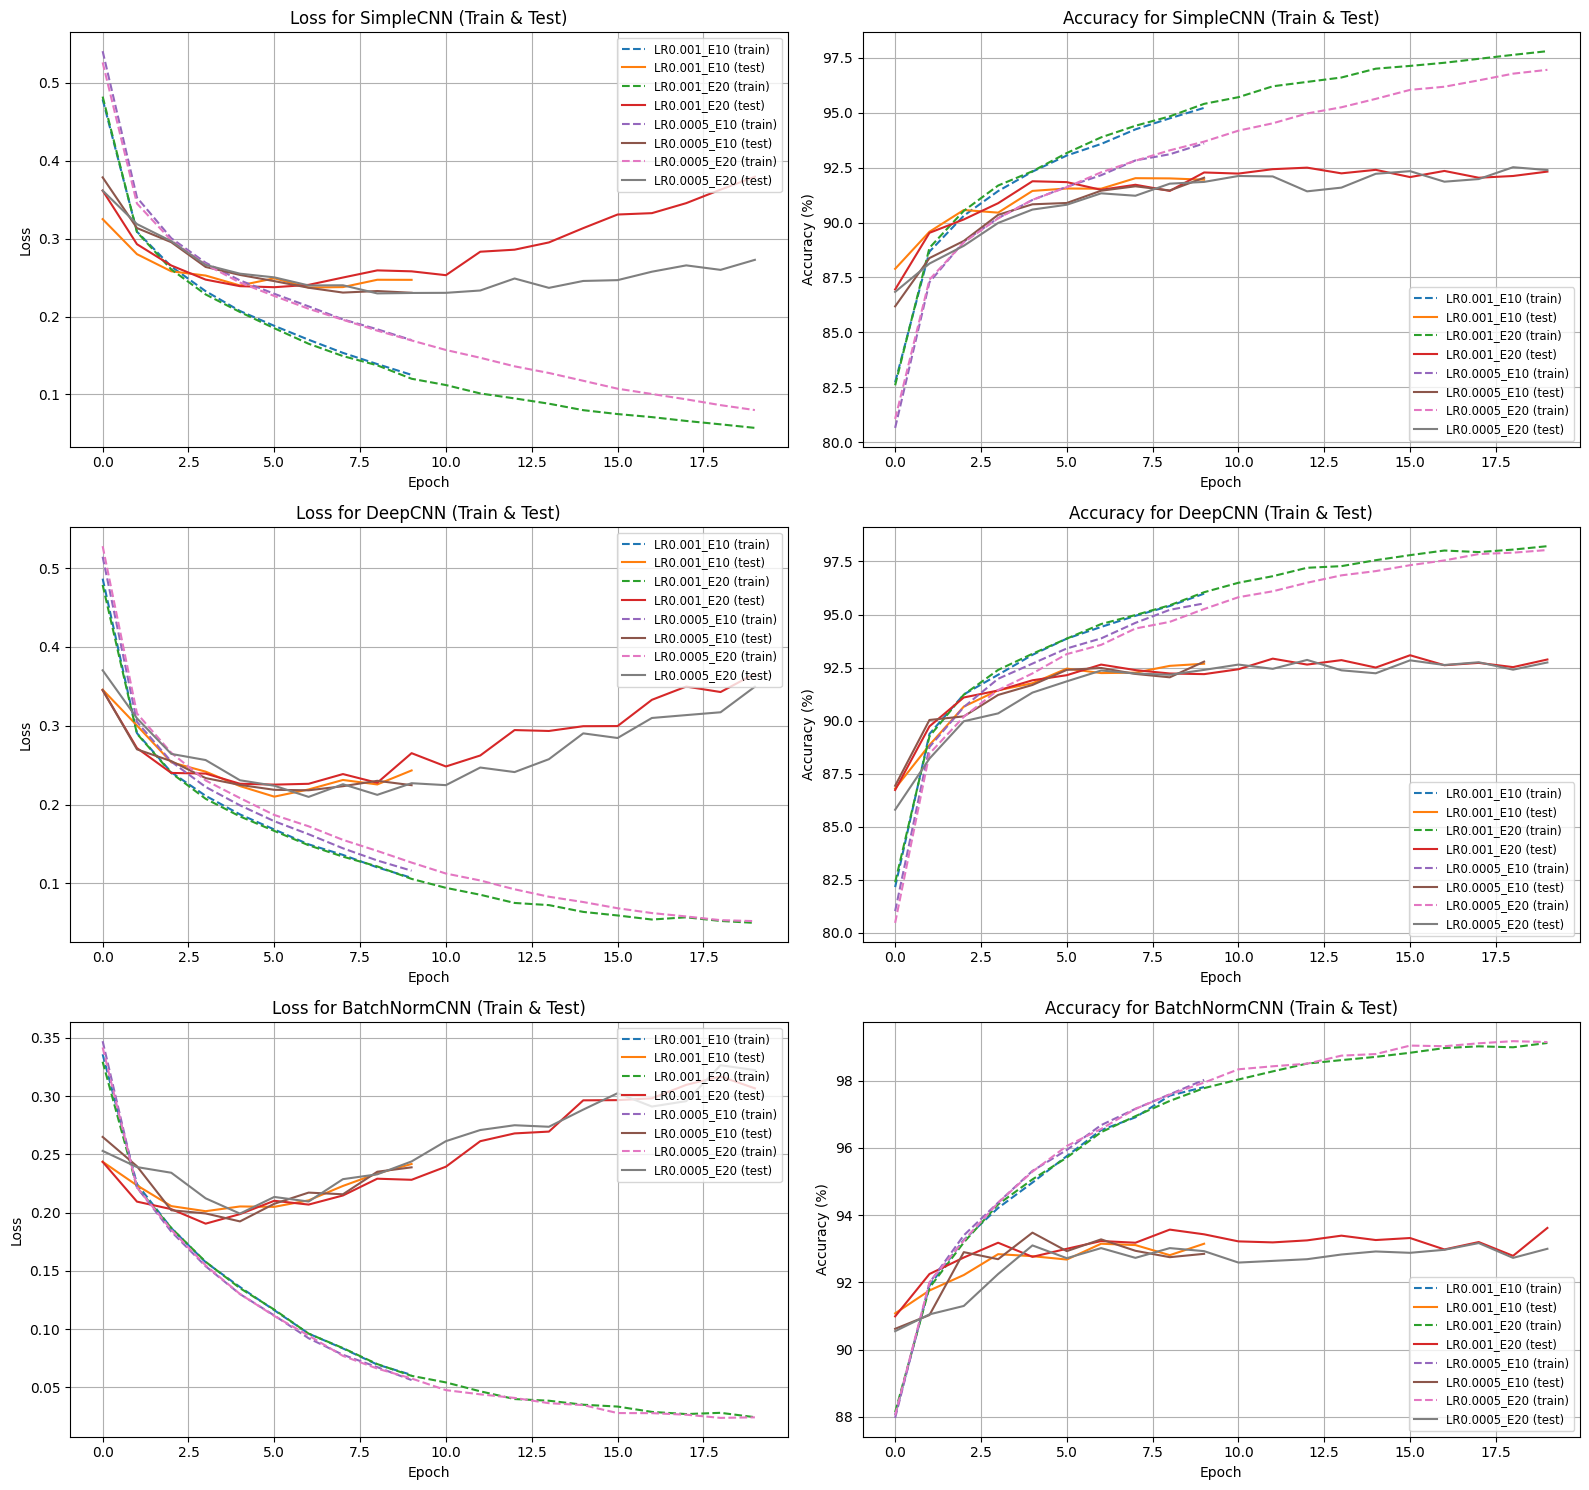


FINAL RESULTS SUMMARY
SimpleCNN_LR0.001_E10: 91.95% test accuracy
SimpleCNN_LR0.001_E20: 92.32% test accuracy
SimpleCNN_LR0.0005_E10: 92.04% test accuracy
SimpleCNN_LR0.0005_E20: 92.39% test accuracy
DeepCNN_LR0.001_E10: 92.68% test accuracy
DeepCNN_LR0.001_E20: 92.88% test accuracy
DeepCNN_LR0.0005_E10: 92.78% test accuracy
DeepCNN_LR0.0005_E20: 92.74% test accuracy
BatchNormCNN_LR0.001_E10: 93.15% test accuracy
BatchNormCNN_LR0.001_E20: 93.62% test accuracy
BatchNormCNN_LR0.0005_E10: 92.85% test accuracy
BatchNormCNN_LR0.0005_E20: 93.00% test accuracy

 Best overall result: BatchNormCNN_LR0.001_E20 with 93.62% accuracy.


In [23]:
models_to_test = {
    'SimpleCNN': TwoLayerCNN,
    'DeepCNN': FourLayerCNN,
    'BatchNormCNN': BatchNormCNN
}

models_list = list(models_to_test.keys())

# hyperparameter grid
learning_rates = [0.001, 0.0005]
num_epochs = [10, 20]

results = {}

for name, ModelClass in models_to_test.items():
  for lr_val in learning_rates:
    for epoch_val in num_epochs:

      experiment_key = f"{name}_LR{lr_val}_E{epoch_val}"

      print("\n")
      print(f"Training {name}")
      print(f"Hyperparameters: LR={lr_val}, Epochs={epoch_val}")
      print("\n")

      model = ModelClass()

      train_loss, train_acc, test_loss, test_acc = train_model(
          model, train_loader, test_loader, epoch_val, lr_val)

      # store results
      results[experiment_key] = {
          'lr': lr_val,
          'epochs': epoch_val,
          'train_loss': train_loss,
          'train_acc': train_acc,
          'test_loss': test_loss,
          'test_acc': test_acc,
          'final_test_acc': test_acc[-1]
      }

plot_training_history(results, models_list)

# Print summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

best_acc = -1
best_name = ""

for name, result in results.items():
    print(f"{name}: {result['final_test_acc']:.2f}% test accuracy")
    if result['final_test_acc'] > best_acc:
        best_acc = result['final_test_acc']
        best_name = name

print(f"\n Best overall result: {best_name} with {best_acc:.2f}% accuracy.")

## **Conclusion:**

The best performing CNN model turned out to be the BatchNormCNN with learning rate 0.001 trained for 20 epochs as it achieved 93.62% test accuracy.

as expected, the CNN significantly outperformed the best ML model (random Forest at 87.64% accuracy) showing the superiority of deep learning approaches for image classification tasks as they can learn spatial features directly from raw pixel data, whereas traditional ML models rely on flattened feature vectors that discard these spatial relationships.

All CNN variants (91.95-93.62%) surpassed the traditional ML baselines (84.29-87.64%), with even the simplest SimpleCNN also outperforming random forest (which was the best ML algo that we tried)